# A repository to visualize AST of functions

## DATA PARSING

In [2]:
import ast
import requests
import inspect
import bikewise

In [3]:
# test function
def hello():
    print('hello world!')
    
def more_hello():
    for i in range(10):
        print('hello world!')
    return 'yes'
                
def ira():
    for i in range(25):
        print("i am %d years old!" % (i+1))
    print('heyyy')
    if ira.__name__ == 'ira':
        print('yesss!')

In [4]:
# get source code str + ast.parse
import functools

def insp_parse(method):
    
    @functools.wraps(method)
    def wrapper(*args, **kwargs):
        if isinstance(args[0], str):
            p_func = ast.parse(args[0])
        else:
            _func = inspect.getsource(args[0])
            p_func = ast.parse(_func)
        de_parsed = method(p_func, **kwargs)
        json_parsed = json.loads(de_parsed)
        return json_parsed
    
    return wrapper

In [5]:
# get ast from func

from _ast import AST
import json
from pprint import pprint

@insp_parse
def ast2json(node):
    def _format(node):
        if isinstance( node, AST ):
            fields = [ ( '_PyType', _format( node.__class__.__name__ ) ) ]
            fields += [ ( a, _format( b ) ) for a, b in iter_fields( node ) ]
            return '{ %s }' % ', '.join( ( '"%s": %s' % field for field in fields ) )

        if isinstance( node, list ):
            return '[ %s ]' % ', '.join( [ _format( x ) for x in node ] )
        if isinstance(node, bytes):
            return json.dumps(node.decode("utf-8"))
        return json.dumps(node)


    return _format( node )



def iter_fields( node ):
    try:
        for field in node._fields:
            yield field, getattr( node, field )
    except AttributeError:
        pass

In [6]:
# pprint before manipulation of ast.dump

pprint(ast.dump(ast.parse(inspect.getsource(hello))))

("Module(body=[FunctionDef(name='hello', args=arguments(args=[], vararg=None, "
 'kwonlyargs=[], kw_defaults=[], kwarg=None, defaults=[]), '
 "body=[Expr(value=Call(func=Name(id='print', ctx=Load()), args=[Str(s='hello "
 "world!')], keywords=[]))], decorator_list=[], returns=None)])")


In [7]:
# pprint after manipulation of ast.dump

pprint(ast2json(hello))

{'_PyType': 'Module',
 'body': [{'_PyType': 'FunctionDef',
           'args': {'_PyType': 'arguments',
                    'args': [],
                    'defaults': [],
                    'kw_defaults': [],
                    'kwarg': None,
                    'kwonlyargs': [],
                    'vararg': None},
           'body': [{'_PyType': 'Expr',
                     'value': {'_PyType': 'Call',
                               'args': [{'_PyType': 'Str',
                                         's': 'hello world!'}],
                               'func': {'_PyType': 'Name',
                                        'ctx': {'_PyType': 'Load'},
                                        'id': 'print'},
                               'keywords': []}}],
           'decorator_list': [],
           'name': 'hello',
           'returns': None}]}


## GRAPHING

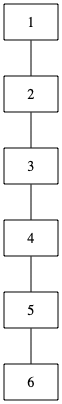

In [122]:
# have something to graph - an example
import pydot_ng as pydot
from IPython.display import Image, display

def grapher(graph, li):
    for index, i in enumerate(li):
        if not index:
            node_from = pydot.Node(i, shape='box', label=i)
            continue
        node_to = pydot.Node(i, shape='box', label=i)
        graph.add_node(node_from)
        graph.add_node(node_to)
        graph.add_edge(pydot.Edge(node_from, node_to))
        node_from = node_to
        
def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)
        
graph = pydot.Dot(graph_type='graph')
grapher(graph, [1,2,3,4,5,6])
view_pydot(graph)

In [9]:
# VERSION 1
def _grapher(graph, dictionary, _node_from=''):
    if not dictionary:
        pass
    else:
        for key, value in dictionary.items():
            if not _node_from:
                _node_from = value
                continue
            if not value:
                draw(_node_from, key)
            if key == '_PyType':
                draw(_node_from, value)
                _node_from = value
                continue
            if isinstance(value, dict):
                _grapher(graph, value, _node_from=_node_from)
            if isinstance(value, list):
                [_grapher(graph, item, _node_from=_node_from) for item in value]
            if isinstance(value, str):
                draw(_node_from, value)
            
def draw(parent_name, child_name):
#     if docs too long, it won't fit on graph
    if len(child_name) > 2500:
        child_name = '~~~DOCS: too long to fit on graph~~~'
    illegal_char = (',', '\\', '/')
    if parent_name == 'node':
        parent_name = '_node'
    if child_name == 'node':
        child_name = '_node'
    if parent_name in illegal_char or child_name in illegal_char:
        pass
    if not child_name:
        pass
    else:
#         parent_node = pydot.Node(parent_name, shape='box', label=parent_name)
#         child_node = pydot.Node(child_name, shape='box', label=child_name)
#         graph.add_node(parent_node)
#         graph.add_node(child_node)
#         graph.add_edge(pydot.Edge(parent_node, child_node))
        edge = pydot.Edge(parent_name, child_name, color='black')
        graph.add_edge(edge)

In [10]:
# check length of string (i.e. docs)

x = '''JSON (JavaScript Object Notation) <http://json.org> is a subset of\nJavaScript syntax (ECMA-262 3rd edition) used as a lightweight data\ninterchange format.\n\n:mod:`json` exposes an API familiar to users of the standard library\n:mod:`marshal` and :mod:`pickle` modules.  It is derived from a\nversion of the externally maintained simplejson library.\n\nEncoding basic Python object hierarchies::\n\n    >>> import json\n    >>> json.dumps(['foo', {'bar': ('baz', None, 1.0, 2)}])\n    '[\"foo\", {\"bar\": [\"baz\", null, 1.0, 2]}]'\n    >>> print(json.dumps(\"\\"foo\bar\"))\n    \"\\"foo\bar\"\n    >>> print(json.dumps('\u1234'))\n    \"\u1234\"\n    >>> print(json.dumps('\\'))\n    \"\\\"\n    >>> print(json.dumps({\"c\": 0, \"b\": 0, \"a\": 0}, sort_keys=True))\n    {\"a\": 0, \"b\": 0, \"c\": 0}\n    >>> from io import StringIO\n    >>> io = StringIO()\n    >>> json.dump(['streaming API'], io)\n    >>> io.getvalue()\n    '[\"streaming API\"]'\n\nCompact encoding::\n\n    >>> import json\n    >>> mydict = {'4': 5, '6': 7}\n    >>> json.dumps([1,2,3,mydict], separators=(',', ':'))\n    '[1,2,3,{\"4\":5,\"6\":7}]'\n\nPretty printing::\n\n    >>> import json\n    >>> print(json.dumps({'4': 5, '6': 7}, sort_keys=True, indent=4))\n    {\n        \"4\": 5,\n        \"6\": 7\n    }\n\nDecoding JSON::\n\n    >>> import json\n    >>> obj = ['foo', {'bar': ['baz', None, 1.0, 2]}]\n    >>> json.loads('[\"foo\", {\"bar\":[\"baz\", null, 1.0, 2]}]') == obj\n    True\n    >>> json.loads('\"\\\"foo\\bar\"') == '\"foo\x08ar'\n    True\n    >>> from io import StringIO\n    >>> io = StringIO('[\"streaming API\"]')\n    >>> json.load(io)[0] == 'streaming API'\n    True\n\nSpecializing JSON object decoding::\n\n    >>> import json\n    >>> def as_complex(dct):\n    ...     if '__complex__' in dct:\n    ...         return complex(dct['real'], dct['imag'])\n    ...     return dct\n    ...\n    >>> json.loads('{\"__complex__\": true, \"real\": 1, \"imag\": 2}',\n    ...     object_hook=as_complex)\n    (1+2j)\n    >>> from decimal import Decimal\n    >>> json.loads('1.1', parse_float=Decimal) == Decimal('1.1')\n    True\n\nSpecializing JSON object encoding::\n\n    >>> import json\n    >>> def encode_complex(obj):\n    ...     if isinstance(obj, complex):\n    ...         return [obj.real, obj.imag]\n    ...     raise TypeError(f'Object of type {obj.__class__.__name__} '\n    ...                     f'is not JSON serializable')\n    ...\n    >>> json.dumps(2 + 1j, default=encode_complex)\n    '[2.0, 1.0]'\n    >>> json.JSONEncoder(default=encode_complex).encode(2 + 1j)\n    '[2.0, 1.0]'\n    >>> ''.join(json.JSONEncoder(default=encode_complex).iterencode(2 + 1j))\n    '[2.0, 1.0]'\n\n\nUsing json.tool from the shell to validate and pretty-print::\n\n    $ echo '{\"json\":\"obj\"}' | python -m json.tool\n    {\n        \"json\": \"obj\"\n    }\n    $ echo '{ 1.2:3.4}' | python -m json.tool\n    Expecting property name enclosed in double quotes: line 1 column 3 (char 2)\n'''
print(len(x))
y = """\nRequests HTTP Library\n~~~~~~~~~~~~~~~~~~~~~\n\nRequests is an HTTP library, written in Python, for human beings. Basic GET\nusage:\n\n   >>> import requests\n   >>> r = requests.get('https://www.python.org')\n   >>> r.status_code\n   200\n   >>> 'Python is a programming language' in r.content\n   True\n\n... or POST:\n\n   >>> payload = dict(key1='value1', key2='value2')\n   >>> r = requests.post('https://httpbin.org/post', data=payload)\n   >>> print(r.text)\n   {\n     ...\n     \"form\": {\n       \"key2\": \"value2\",\n       \"key1\": \"value1\"\n     },\n     ...\n   }\n\nThe other HTTP methods are supported - see `requests.api`. Full documentation\nis at <http://python-requests.org>.\n\n:copyright: (c) 2017 by Kenneth Reitz.\n:license: Apache 2.0, see LICENSE for more details.\n"""
print(len(y))

2821
756


In [11]:
pprint(ast2json(hello))

{'_PyType': 'Module',
 'body': [{'_PyType': 'FunctionDef',
           'args': {'_PyType': 'arguments',
                    'args': [],
                    'defaults': [],
                    'kw_defaults': [],
                    'kwarg': None,
                    'kwonlyargs': [],
                    'vararg': None},
           'body': [{'_PyType': 'Expr',
                     'value': {'_PyType': 'Call',
                               'args': [{'_PyType': 'Str',
                                         's': 'hello world!'}],
                               'func': {'_PyType': 'Name',
                                        'ctx': {'_PyType': 'Load'},
                                        'id': 'print'},
                               'keywords': []}}],
           'decorator_list': [],
           'name': 'hello',
           'returns': None}]}


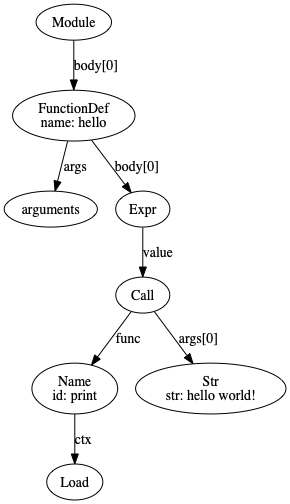

In [12]:
import ctree
import json

def f(a):
    for x in range(10):
        a[x] += x

tree1 = ctree.get_ast(hello)
ctree.ipython_show_ast(tree1)

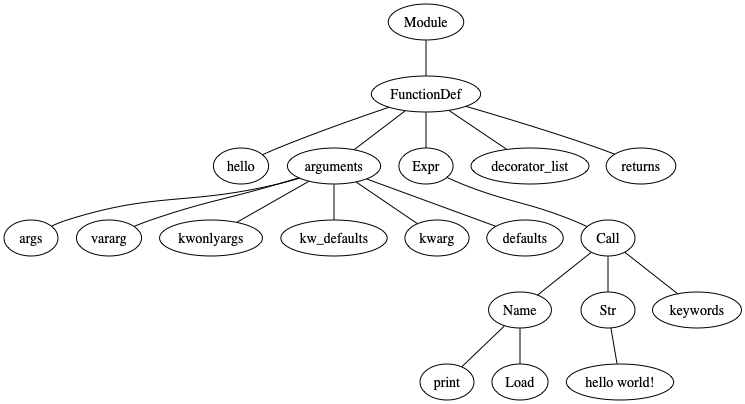

True

In [14]:
import conda, docutils, pathlib2, rope, xlrd, zipp, sklearn

graph = pydot.Dot(graph_type='graph')
_grapher(graph, ast2json(hello))
# print(graph.to_string())
view_pydot(graph)
graph.write_png('test.png')

In [15]:
pprint(ast2json(hello))

{'_PyType': 'Module',
 'body': [{'_PyType': 'FunctionDef',
           'args': {'_PyType': 'arguments',
                    'args': [],
                    'defaults': [],
                    'kw_defaults': [],
                    'kwarg': None,
                    'kwonlyargs': [],
                    'vararg': None},
           'body': [{'_PyType': 'Expr',
                     'value': {'_PyType': 'Call',
                               'args': [{'_PyType': 'Str',
                                         's': 'hello world!'}],
                               'func': {'_PyType': 'Name',
                                        'ctx': {'_PyType': 'Load'},
                                        'id': 'print'},
                               'keywords': []}}],
           'decorator_list': [],
           'name': 'hello',
           'returns': None}]}


In [163]:
# VERSION 2.1
def _grapher(graph, dictionary, _node_from=''):
    if not dictionary:
        pass
    else:
        for key, value in dictionary.items():
            esc_keys = ('s', 'id', 'name', 'attr', 'arg')
            if not _node_from:
                _node_from = value
                continue
            if not value:
                continue
            if key == '_PyType':
                for i in esc_keys:
                    if dict.get(dictionary, i):
                        if i == 's':
                            value = f"{value}\nstr: {dictionary[i]}"
                        else:
                            value = f"{value}\n{i}: {dictionary[i]}"
                draw(_node_from, value)
                _node_from = value
                continue
            if isinstance(value, dict):
                _grapher(graph, value, _node_from=_node_from)
            if isinstance(value, list):
                [_grapher(graph, item, _node_from=_node_from) for item in value]
            if isinstance(value, str):
                if key in esc_keys:
                    continue
                draw(_node_from, value)
            
def draw(parent_name, child_name):
#     if docs too long, it won't fit on graph
    if len(child_name) > 2500:
        child_name = '~~~DOCS: too long to fit on graph~~~'
    illegal_char = (',', '\\', '/')
    if parent_name == 'node':
        parent_name = '_node'
    if child_name == 'node':
        child_name = '_node'
    if parent_name in illegal_char or child_name in illegal_char:
        return
    if not child_name:
        return
    else:
#         parent_node = pydot.Node(parent_name, shape='box', label=parent_name)
#         child_node = pydot.Node(child_name, shape='box', label=child_name)
#         graph.add_node(parent_node)
#         graph.add_node(child_node)
#         graph.add_edge(pydot.Edge(parent_node, child_node))
        edge = pydot.Edge(parent_name, child_name, color='black')
        graph.add_edge(edge)
    return child_name

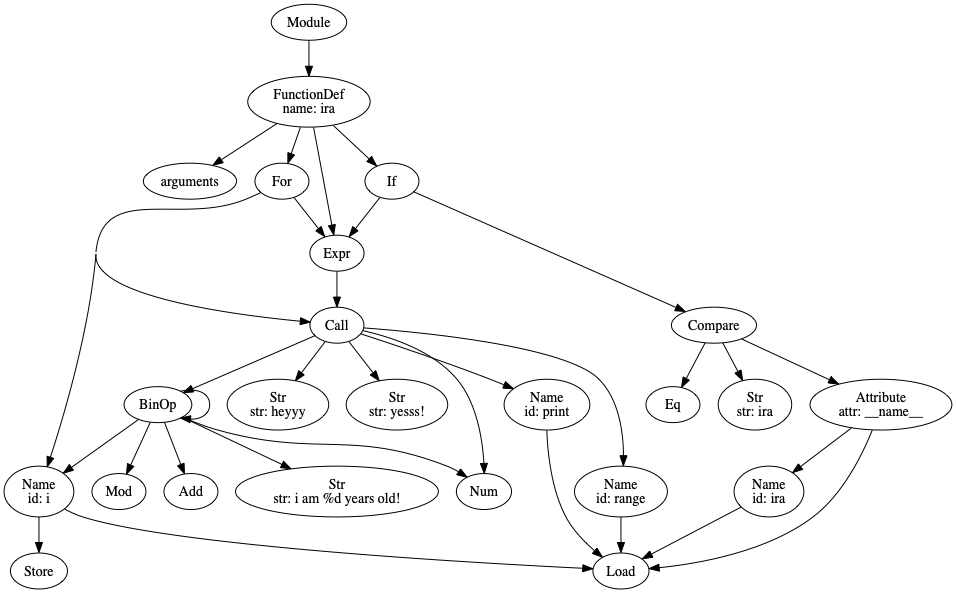

True

In [178]:
import conda, docutils, pathlib2, rope, xlrd, zipp, sklearn, pandas, datetime

graph = pydot.Dot(graph_type='digraph', strict=True, constraint=True, concentrate=True)
_grapher(graph, ast2json(ira))
# print(graph.to_string())
view_pydot(graph)
graph.write_png('test.png')

In [132]:
print(graph.to_string())

strict graph G {
Module -- "FunctionDef\nname: more_hello"  [color=black];
"FunctionDef\nname: more_hello" -- arguments  [color=black];
"FunctionDef\nname: more_hello" -- For  [color=black];
For -- "Name\nid: i"  [color=black];
"Name\nid: i" -- Store  [color=black];
For -- Call  [color=black];
Call -- "Name\nid: range"  [color=black];
"Name\nid: range" -- Load  [color=black];
Call -- Num  [color=black];
For -- Expr  [color=black];
Expr -- Call  [color=black];
Call -- "Name\nid: print"  [color=black];
"Name\nid: print" -- Load  [color=black];
Call -- "Str\ns: hello world!"  [color=black];
"FunctionDef\nname: more_hello" -- Return  [color=black];
Return -- "Str\ns: yes"  [color=black];
}



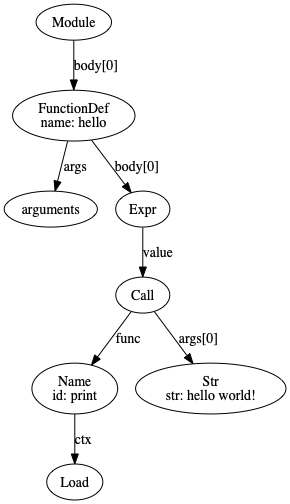

In [162]:
import ctree
import json

def f(a):
    for x in range(10):
        a[x] += x

tree1 = ctree.get_ast(hello)
ctree.ipython_show_ast(tree1)

In [142]:
pprint(ast2json(f))

{'_PyType': 'Module',
 'body': [{'_PyType': 'FunctionDef',
           'args': {'_PyType': 'arguments',
                    'args': [{'_PyType': 'arg',
                              'annotation': None,
                              'arg': 'a'}],
                    'defaults': [],
                    'kw_defaults': [],
                    'kwarg': None,
                    'kwonlyargs': [],
                    'vararg': None},
           'body': [{'_PyType': 'For',
                     'body': [{'_PyType': 'AugAssign',
                               'op': {'_PyType': 'Add'},
                               'target': {'_PyType': 'Subscript',
                                          'ctx': {'_PyType': 'Store'},
                                          'slice': {'_PyType': 'Index',
                                                    'value': {'_PyType': 'Name',
                                                              'ctx': {'_PyType': 'Load'},
                                       

{'_PyType': 'Module',
 'body': [{'_PyType': 'FunctionDef',
           'args': {'_PyType': 'arguments',
                    'args': [],
                    'defaults': [],
                    'kw_defaults': [],
                    'kwarg': None,
                    'kwonlyargs': [],
                    'vararg': None},
           'body': [{'_PyType': 'For',
                     'body': [{'_PyType': 'Expr',
                               'value': {'_PyType': 'Call',
                                         'args': [{'_PyType': 'Str',
                                                   's': 'hello world!'}],
                                         'func': {'_PyType': 'Name',
                                                  'ctx': {'_PyType': 'Load'},
                                                  'id': 'print'},
                                         'keywords': []}}],
                     'iter': {'_PyType': 'Call',
                              'args': [{'_PyType': 'Num', 'n': 10}

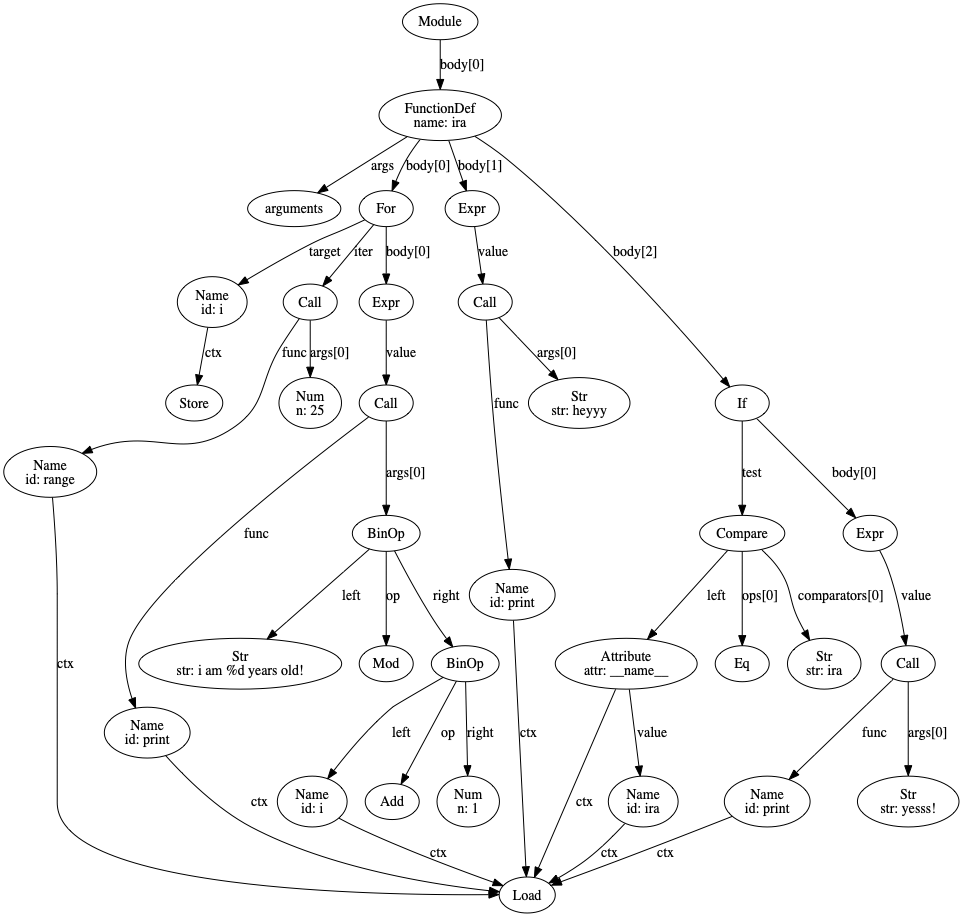

In [415]:
import ctree
import json

def f(a):
    for x in range(10):
        a[x] += x

tree1 = ctree.get_ast(ira)
ctree.ipython_show_ast(tree1)

In [86]:
bool(dict.get({'a':'b', 'b':'c'}, ('b','a')))

False

In [37]:
from first import first

def has_key(key):
    return [k in ('s', 'id', 'name') for k,v in key.items()]

first([{'s':'a'}], key=has_key)

{'s': 'a'}

In [449]:
# VERSION 3
import random

def _grapher(graph, dictionary, _node_from=''):
    if not dictionary:
        pass
    else:
        for key, value in dictionary.items():
            esc_keys = ('s', 'id', 'name', 'attr', 'arg')
            if not _node_from:
                _node_from = value
                continue
            if not value:
                continue
            if key == '_PyType':
                for i in esc_keys:
                    if dict.get(dictionary, i):
                        if i == 's':
                            value = f"{value}\nstr: {dictionary[i]}"
                        else:
                            value = f"{value}\n{i}: {dictionary[i]}"
                draw(_node_from, value, )
                _node_from = value
                continue
            if isinstance(value, dict):
                _grapher(graph, value, _node_from=_node_from)
            if isinstance(value, list):
                [_grapher(graph, item, _node_from=_node_from) for item in value]
            if isinstance(value, str):
                if key in esc_keys:
                    continue
                draw(_node_from, value)
            
def draw(parent_name, child_name):
#     if docs too long, it won't fit on graph
    if len(child_name) > 2500:
        child_name = '~~~DOCS: too long to fit on graph~~~'
    illegal_char = (',', '\\', '/')
    if parent_name == 'node':
        parent_name = '_node'
    if child_name == 'node':
        child_name = '_node'
    if not child_name:
        return
    else:
#         parent_node = pydot.Node(parent_name, shape='box', label=parent_name)
#         child_node = pydot.Node(child_name, shape='box', label=child_name)
#         graph.add_node(parent_node)
#         graph.add_node(child_node)
#         graph.add_edge(pydot.Edge(parent_node, child_node))
        edge = pydot.Edge(parent_name, child_name, color='black')  # use label='\E' for default labels, style='invis' to hide edge
        graph.add_edge(edge)
    return child_name

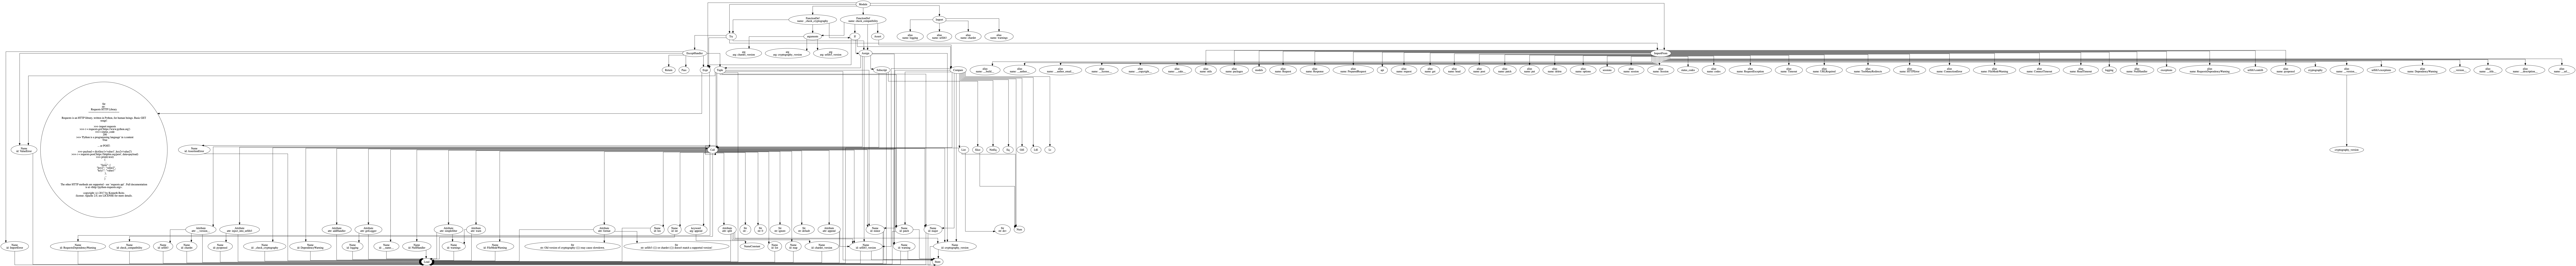

True

In [450]:
import conda, docutils, pathlib2, rope, xlrd, zipp, sklearn, pandas, datetime

graph = pydot.Dot(graph_type='digraph', strict=True, constraint=True, concentrate=True, splines='ortho')
_grapher(graph, ast2json(requests))
# print(graph.to_string())
view_pydot(graph)
graph.write_png('test.png')

In [569]:
# VERSION 4 - try activating nodes and hashing parent node
# SOLVED! 12:50AM - polished 1:50AM
import random

def _grapher(graph, dictionary, _node_from='', hash_node='__init__'):
    if dictionary:
        for key, value in dictionary.items():
            esc_keys = ('n', 's', 'id', 'name', 'attr', 'arg')
            if not value:
                continue
            if not _node_from:
                _node_from = value
                continue
            if key == '_PyType':
                for i in esc_keys:
                    if dict.get(dictionary, i):
                        if i == 's':
                            value = f"{value}\nstr: {dictionary[i]}"
                        else:
                            value = f"{value}\n{i}: {dictionary[i]}"
                hash_node = draw(_node_from, value, parent_hash=hash_node)
                _node_from = value
                continue
            if isinstance(value, dict):
                _grapher(graph, value, _node_from=_node_from, hash_node=hash_node)
            if isinstance(value, list):
                [_grapher(graph, item, _node_from=_node_from, hash_node=hash_node) for item in value]
                
            
def draw(parent_name, child_name, parent_hash):
#     if docs too long, it won't fit on graph
    if len(child_name) > 2500:
        child_name = '~~~DOCS: too long to fit on graph~~~'
    illegal_char = (',', '\\', '/')
    if parent_name == 'node':
        parent_name = '_node'
    if child_name == 'node':
        child_name = '_node'
    if not child_name:
        return
    else:
        parent_node = pydot.Node(parent_hash, label=parent_name, shape='box')
        child_hash = str(random.randint(1,10e9))
        child_node = pydot.Node(child_hash, shape='box', label=child_name)
        graph.add_node(parent_node)
        graph.add_node(child_node)
        graph.add_edge(pydot.Edge(parent_node, child_node))
#         edge = pydot.Edge(parent_name, child_name, color='black')  # use label='\E' for default labels, style='invis' to hide edge
#         graph.add_edge(edge)
    return child_hash

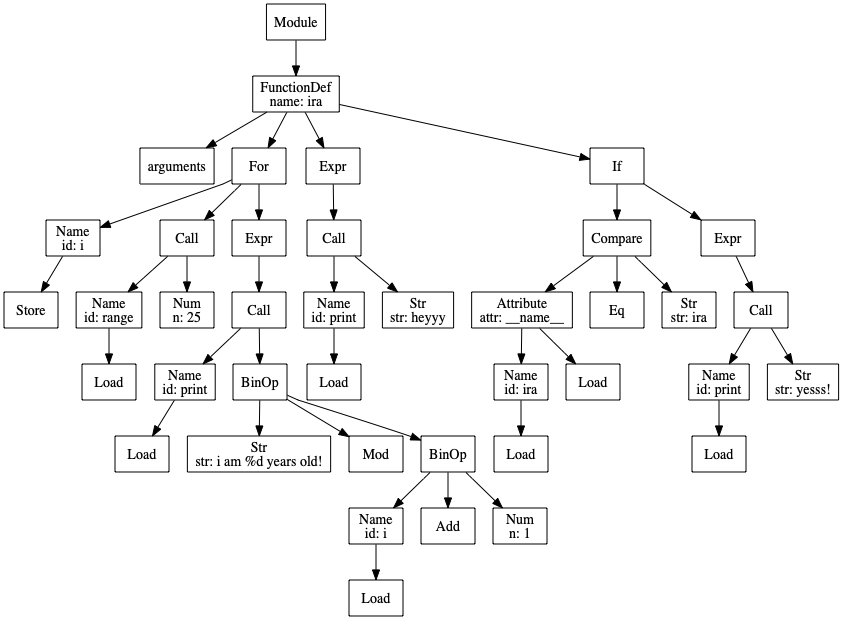

True

In [570]:
import conda, docutils, pathlib2, rope, xlrd, zipp, sklearn, pandas, datetime

graph = pydot.Dot(graph_type='digraph', strict=True, constraint=True, concentrate=True, splines='polyline')
_grapher(graph, ast2json(ira))
# print(graph.to_string())
view_pydot(graph)
graph.write_png('test.png')

In [563]:
pprint(ast2json(more_hello))

{'_PyType': 'Module',
 'body': [{'_PyType': 'FunctionDef',
           'args': {'_PyType': 'arguments',
                    'args': [],
                    'defaults': [],
                    'kw_defaults': [],
                    'kwarg': None,
                    'kwonlyargs': [],
                    'vararg': None},
           'body': [{'_PyType': 'For',
                     'body': [{'_PyType': 'Expr',
                               'value': {'_PyType': 'Call',
                                         'args': [{'_PyType': 'Str',
                                                   's': 'hello world!'}],
                                         'func': {'_PyType': 'Name',
                                                  'ctx': {'_PyType': 'Load'},
                                                  'id': 'print'},
                                         'keywords': []}}],
                     'iter': {'_PyType': 'Call',
                              'args': [{'_PyType': 'Num', 'n': 10}

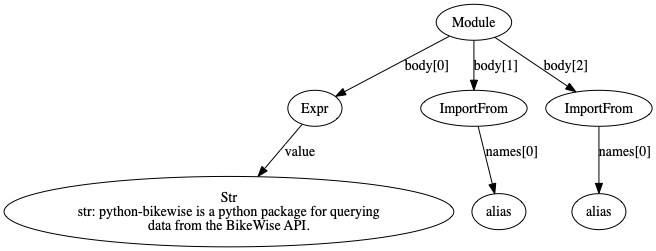

In [424]:
tree1 = ctree.get_ast(bikewise)
ctree.ipython_show_ast(tree1)

In [418]:
print(graph.to_string())
print(dir(pydot.Edge))

strict digraph G {
concentrate=True;
constraint=True;
splines=polyline;
__init__ [label=Module, shape=box];
22429750 [label=Assign, shape=box];
__init__ -> 22429750;
22429750 [label=Assign, shape=box];
100868197 [label="Name\nid: __docformat__", shape=box];
22429750 -> 100868197;
100868197 [label="Name\nid: __docformat__", shape=box];
851650164 [label=Store, shape=box];
100868197 -> 851650164;
22429750 [label=Assign, shape=box];
961398968 [label="Str\nstr: restructuredtext", shape=box];
22429750 -> 961398968;
__init__ [label=Module, shape=box];
60745149 [label=Assign, shape=box];
__init__ -> 60745149;
60745149 [label=Assign, shape=box];
794083338 [label="Name\nid: hard_dependencies", shape=box];
60745149 -> 794083338;
794083338 [label="Name\nid: hard_dependencies", shape=box];
510315589 [label=Store, shape=box];
794083338 -> 510315589;
60745149 [label=Assign, shape=box];
23712472 [label=Tuple, shape=box];
60745149 -> 23712472;
23712472 [label=Tuple, shape=box];
193014744 [label="Str\ns

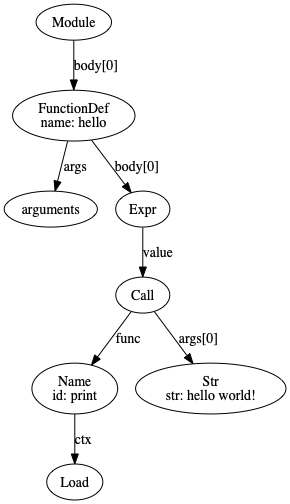

In [247]:
import ctree
import json

def f(a):
    for x in range(10):
        a[x] += x

tree1 = ctree.get_ast(hello)
ctree.ipython_show_ast(tree1)

In [267]:
pprint(ast2json(hello))

{'_PyType': 'Module',
 'body': [{'_PyType': 'FunctionDef',
           'args': {'_PyType': 'arguments',
                    'args': [],
                    'defaults': [],
                    'kw_defaults': [],
                    'kwarg': None,
                    'kwonlyargs': [],
                    'vararg': None},
           'body': [{'_PyType': 'Expr',
                     'value': {'_PyType': 'Call',
                               'args': [{'_PyType': 'Str',
                                         's': 'hello world!'}],
                               'func': {'_PyType': 'Name',
                                        'ctx': {'_PyType': 'Load'},
                                        'id': 'print'},
                               'keywords': []}}],
           'decorator_list': [],
           'name': 'hello',
           'returns': None}]}
